In [2]:
import tensorflow as tf
from tensorflow.keras import datasets,layers, models
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import PIL
import pathlib
from tensorflow import keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

batch_size = 32
img_height = 180
img_width = 180

In [5]:
folders="/content/drive/MyDrive/LnB project/images"
train_ds = tf.keras.utils.image_dataset_from_directory(
  folders,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1821 files belonging to 4 classes.
Using 1457 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  folders,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1821 files belonging to 4 classes.
Using 364 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['angry', 'happy', 'relaxed', 'sad']


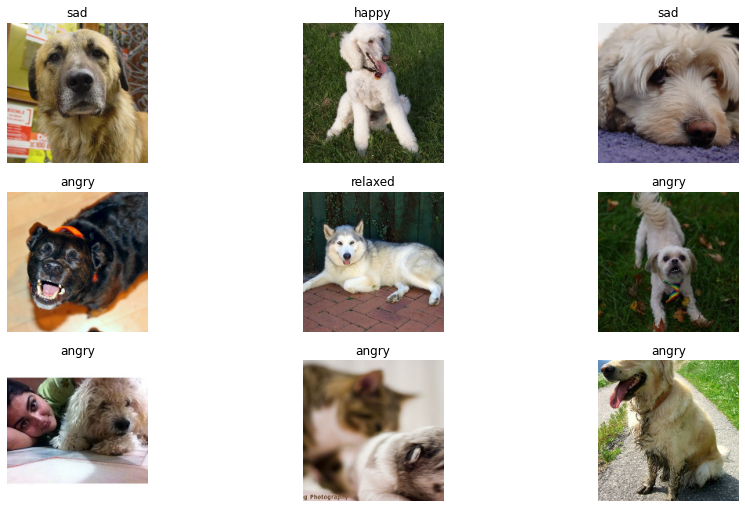

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
46/46 [==============================] - 91s 2s/step - loss: 1.1326 - accuracy: 0.6280 - val_loss: 1.0316 - val_accuracy: 0.6511
Epoch 2/10
46/46 [==============================] - 55s 1s/step - loss: 1.0519 - accuracy: 0.6404 - val_loss: 1.0311 - val_accuracy: 0.6511
Epoch 3/10
46/46 [==============================] - 48s 1s/step - loss: 1.0283 - accuracy: 0.6404 - val_loss: 1.0500 - val_accuracy: 0.6511
Epoch 4/10
46/46 [==============================] - 47s 1s/step - loss: 0.9661 - accuracy: 0.6410 - val_loss: 1.0911 - val_accuracy: 0.6456
Epoch 5/10
46/46 [==============================] - 48s 1s/step - loss: 0.8311 - accuracy: 0.6740 - val_loss: 1.1849 - val_accuracy: 0.6154
Epoch 6/10
46/46 [==============================] - 50s 1s/step - loss: 0.6235 - accuracy: 0.7577 - val_loss: 1.5684 - val_accuracy: 0.5714
Epoch 7/10
46/46 [==============================] - 48s 1s/step - loss: 0.4168 - accuracy: 0.8497 - val_loss: 1.6736 - val_accuracy: 0.5330
Epoch 8/10
46/46 [==

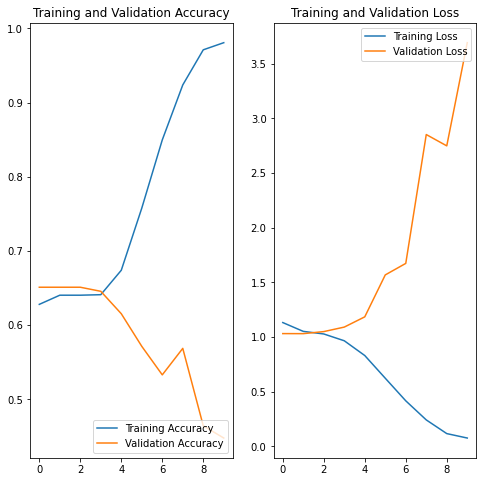

In [17]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

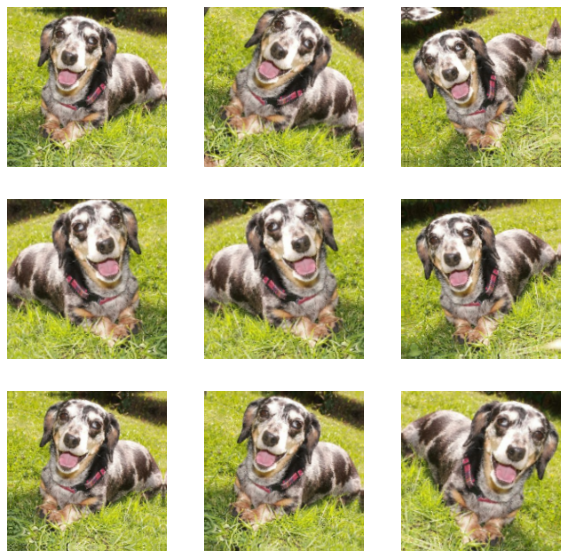

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [23]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
46/46 [==============================] - 57s 1s/step - loss: 1.1516 - accuracy: 0.6314 - val_loss: 1.0571 - val_accuracy: 0.6511
Epoch 2/15
46/46 [==============================] - 57s 1s/step - loss: 1.0644 - accuracy: 0.6404 - val_loss: 1.0270 - val_accuracy: 0.6511
Epoch 3/15
46/46 [==============================] - 59s 1s/step - loss: 1.0423 - accuracy: 0.6404 - val_loss: 1.0148 - val_accuracy: 0.6511
Epoch 4/15
46/46 [==============================] - 58s 1s/step - loss: 1.0316 - accuracy: 0.6404 - val_loss: 1.0138 - val_accuracy: 0.6511
Epoch 5/15
46/46 [==============================] - 61s 1s/step - loss: 1.0309 - accuracy: 0.6404 - val_loss: 1.0112 - val_accuracy: 0.6511
Epoch 6/15
46/46 [==============================] - 59s 1s/step - loss: 1.0343 - accuracy: 0.6404 - val_loss: 1.0121 - val_accuracy: 0.6511
Epoch 7/15
46/46 [==============================] - 59s 1s/step - loss: 1.0235 - accuracy: 0.6404 - val_loss: 1.0207 - val_accuracy: 0.6511
Epoch 8/15
46/46 [==

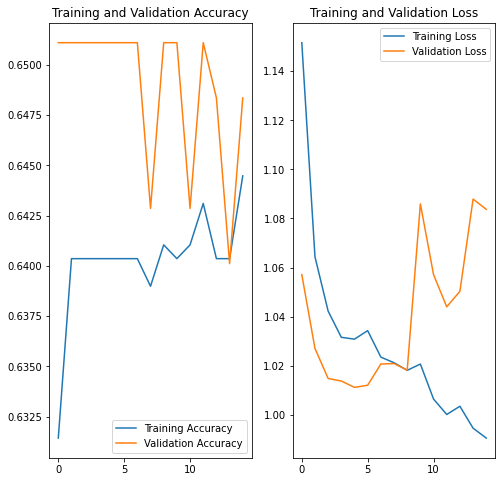

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:

Unused_floder="/content/drive/MyDrive/LnB project/images/happy/102148537_8f11229420_b.jpg"
img = tf.keras.utils.load_img(
    Unused_floder, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 39ms/step
This image most likely belongs to angry with a 88.89 percent confidence.


In [34]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [35]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [36]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [37]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

assert np.allclose(predictions, predictions_lite)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to angry with a 88.89 percent confidence.
